# Comparing Simple linear regression to Bayesian Linear regression

Ref: https://github.com/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression.ipynb

In [1]:
import numpy as np
from sklearn import linear_model

Define necessary functions.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats


def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)
    
def plot_truth(x, y, label='Truth', color='k--'):
    plt.plot(x, y, color, label=label)

def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'b-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'b-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [3]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, degree):
    return x ** degree


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

## 1. generate synthetic data

In [7]:
f_w0 = -0.3
f_w1 =  0.5


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    '''Sinus function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [24]:
# Training dataset sizes
#N_list = [1, 3, 20, 50]

N = 50 # training dataset size

a = 25.0 # 1/a = sigma**2 AS in our slide
b = 2.0 # b = lamda AS in our slide 

# Training observations in [-1, 1)
X = np.random.rand(N, 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/a)

# Test input
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# test output
y_true = f(X_test, noise_variance=0)

## 2. Simple linear regression: Ordinary Least Squares (OLS)

We use the linear regression model in sklearn. 

In [22]:
reg = linear_model.LinearRegression()

In [23]:
reg.fit(X, t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
y_pred = reg.predict(X_test)

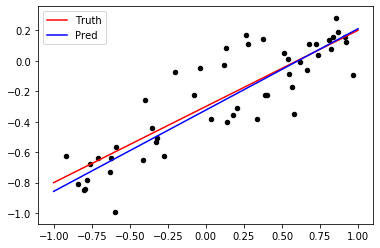

In [29]:
plot_data(X, t)
plot_truth(X_test, y_true, label='Truth', color='r')
plot_truth(X_test, y_pred, label='Pred', color='b')
plt.legend()

## 3. Bayesian linear regression

In [10]:
def posterior(Phi, t, b, a, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = b * np.eye(Phi.shape[1]) + a * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = a * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N
    
def posterior_predictive(Phi_test, m_N, S_N, a):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / a + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [11]:
Phi_N = expand(X, identity_basis_function)

In [12]:
Phi_test = expand(X_test, identity_basis_function)

In [13]:
m_N, S_N = posterior(Phi_N, t, b, a)

In [14]:
y, y_var = posterior_predictive(Phi_test, m_N, S_N, a)

In [15]:
# Draw 5 random weight samples from posterior and compute y values
w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
y_samples = Phi_test.dot(w_samples) # linear func is here 

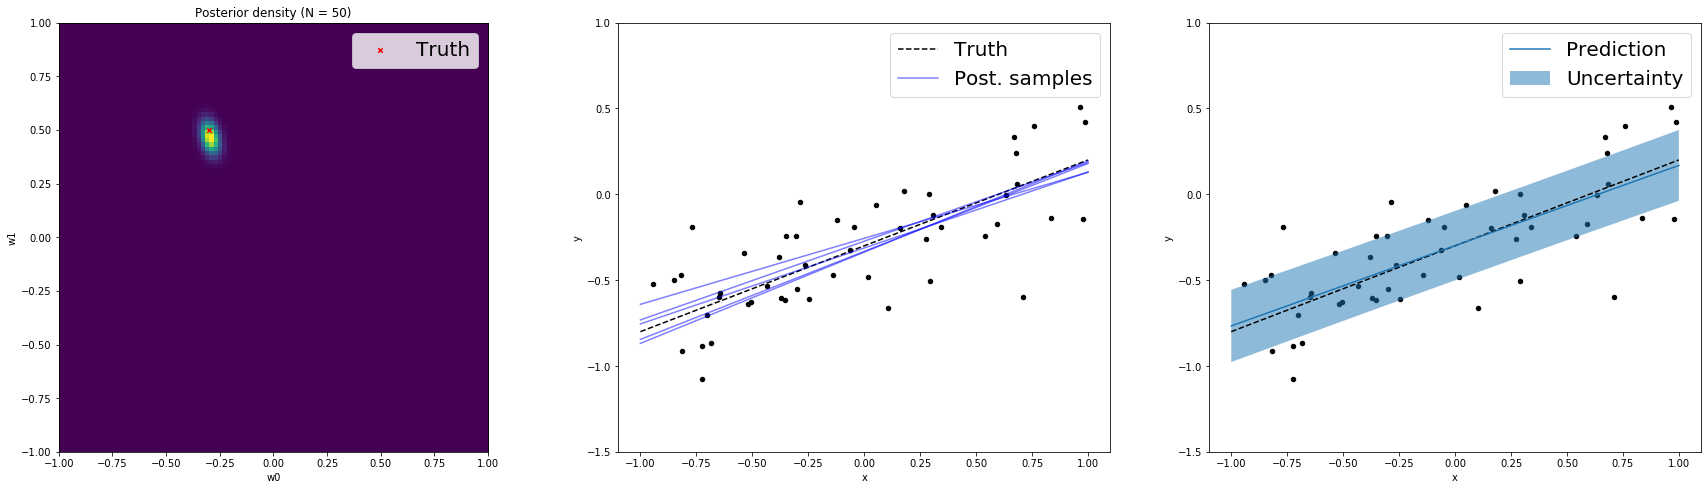

In [25]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.4)

i = 0
plt.subplot(3, 3, i * 3 + 1)
plot_posterior(m_N, S_N, f_w0, f_w1)
plt.title(f'Posterior density (N = {N})')
plt.legend(prop={'size': 20})

plt.subplot(3, 3, i * 3 + 2)
plot_data(X, t)
plot_truth(X_test, y_true)
plot_posterior_samples(X_test, y_samples)
plt.ylim(-1.5, 1.0)
plt.legend(prop={'size': 20})

plt.subplot(3, 3, i * 3 + 3)
plot_data(X, t)
plot_truth(X_test, y_true, label=None)
plot_predictive(X_test, y, np.sqrt(y_var))
plt.ylim(-1.5, 1.0)
plt.legend(prop={'size': 20})